In [1]:
from youtube_transcript_api import YouTubeTranscriptApi
import json
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from tqdm import tqdm

In [2]:
"""
GOAL
I want to automatically segment the podcast into topics (see below, this was manually done by Lex).

ATTEMPT/HYPOTHESIS.1
Treat sentences as documents, episode as corpus
Use TFIDF 
Plot TFIDF for each word for each sentence
TFIDF 'Mike'  | 0 | 0 | 1 | 1 | 0 | 1 | 0 | ...
sentences idx | 1 | 2 | 3 | 4 | 5 | 6 | 7 | ...
Cluster based on the above

ATTEMPT/HYPOTHESIS.2
Use named entity recognition (maybe in combination with TFIDF) and do the same sort of thing.

ATTEMPT/HYPOTHESIS.3
Min or Max some f, (TFIDF?) for some window?

MANUAL
Joe Rogan: Conversations, Ideas, Love, Freedom & the Joe Rogan Experience | Lex Fridman Podcast #127
0:00 - Introduction
1:17 - JRE theme on guitar
1:54 - Fear of mortality
3:24 - Chaos of 2020 and beyond
7:08 - Are we going to be okay?
16:07 - Violence, competition, and Sober October
23:22 - Mike Tyson
24:25 - Managing obsession
26:49 - Jiu jitsu game
32:31 - Best martial art for self defense
36:06 - Second amendment
40:35 - Memorable JRE moments
46:08 - Ideas breed in brains of humans
52:44 - Advice for Lex
1:02:45 - Long-form conversation
1:09:05 - Meaning of life
"""

video_id = "FKCJWkPehdY"
# captions_raw = YouTubeTranscriptApi.get_transcript(video_id)

# with open("lex-captions-FKCJWkPehdY.json" , "w") as f:
#     json.dump(captions_raw, f)

with open("lex-captions-FKCJWkPehdY.json" , "r") as f:
    captions_raw = json.load(f)

In [3]:
words = [c['text'] for c in captions_raw]
words = " ".join(words).split()

# Shit, this has no puncuation
print(" ".join(words)[:300])
# Google' speech2text also does not do a great job at captioning at sentence boundaries
print(words[:2])
print(words[100:110])

the following is a conversation with joe rogan that we recorded after my recent appearance on his podcast the joe rogan experience joe has been a inspiration to me and i thank to millions of people for just being somebody who puts love out there in the world and being genuinely curious about wild id
['the', 'following']
['subscribe', 'on', 'youtube', 'review', 'it', 'with', 'five', 'stars', 'on', 'apple']


In [4]:
"""
I will need some automatic way to create sentences.
Can try three approaches to creating sentences:
    1. Use grammar rules 
    2. Build a classifier 
    3. Naively just use a window of N size
"""

'\nI will need some automatic way to create sentences.\nCan try three approaches to creating sentences:\n    1. Use grammar rules \n    2. Build a classifier \n    3. Naively just use a window of N size\n'

In [5]:
%load_ext autoreload
%autoreload 2
# Should just auto reload lib
# %reload_ext autoreload
# ?autoreload


In [6]:
from lib.TFIDF import TFIDF

# Naive window, chunk into {size} 
def sentences_window(text: List[str], window_size: int) -> List[List[str]]:
    return [" ".join(text[i: i + window_size]) for i in range(0, len(text), window_size)]

sentences = sentences_window(words, window_size=15)
tfidf = TFIDF()
tfidf.generate(sentences)


100%|██████████| 964/964 [00:02<00:00, 477.45it/s]


In [7]:
# For the sentence windows 105 to 110 we print 5 of the top TFIDF scores
tfidf.print_scores(start=105, end=110, n=5)

105
one 0.58397
shot 0.52617
walk 0.49252
noth 0.49252
found 0.47916

106
white 1.3712
guy 0.87595
shot 0.65771
matter 0.63492
black 0.59896

107
mad 2.88624
kind 0.87595
know 0.48778
80 0.0
done 0.0

108
ramp 1.02966
quickli 0.96208
disturb 0.96208
see 0.63001
mean 0.54336

109
101 1.23559
day 0.78533
excus 0.61779
portland 0.57725
riot 0.54848



In [8]:
# This result is frustrating because the words between sentences don't have much
# meaning (see, excuse) or (killers, disturbing) with this model.
# I could tell the model what I want (killers, shot) to have a high correlation of some sort
# BUT that requires me to TELL the computer something, that is too much labeling work for me.

In [9]:
"""
A high TFIDF means the word has a lot of meaning compared to the rest of the corpus
So maybe we take the first ranking TFIDF word and then try to find a group of 
consecutive sentences that minimize it's TFIDF (effectively meaning it is an insignificant word in that phrase)
"""
# I'll call a "window" of "windows" (or a collection of sentences) a phrase
    # This is kinda like our new corpus we will work with
# We want to minimize the sum of the TFIDF scores for a given word
# Start by going to the first sentence that has the word we're

"\nA high TFIDF means the word has a lot of meaning compared to the rest of the corpus\nSo maybe we take the first ranking TFIDF word and then try to find a group of \nconsecutive sentences that minimize it's TFIDF (effectively meaning it is an insignificant word in that phrase)\n"

In [10]:
# But first, let's try to visualize what TFIDF patterns we can see, this time we will use the JRE corpus
tfidf_all_episodes, vocab_all_episodes = (None, None)
episodes = None

with open("./jre-episodes.pickle", "rb") as f:
    episodes = pickle.load(f)
with open("./tfidf-jre-episodes.pickle", "rb") as f:
    tfidf_all_episodes, vocab_all_episodes = pickle.load(f)

In [11]:
ep = episodes[-2]
ep_tfidf = TFIDF()
words_in_ep = ep.text.split()
sentences = sentences_window(words_in_ep, window_size=5)
ep_tfidf.generate(sentences)

100%|██████████| 5529/5529 [00:22<00:00, 241.05it/s]


In [12]:
# Scores for this ep across all episodes
score_list = tfidf_all_episodes[ep.title]
score_tuples = [(vocab_all_episodes[i], score) for i, score in enumerate(score_list)]
top_tfidf_scores_for_ep = sorted(score_tuples, key=lambda x: x[1], reverse=True)

top_tfidf_scores_for_ep[:10]

[('moon', 0.03594686646163839),
 ('diamond', 0.032222520100327424),
 ('jupit', 0.028899296728855158),
 ('earth', 0.0287609182946525),
 ('atmospher', 0.025037004619594926),
 ('multivers', 0.02184906594814874),
 ('space', 0.0206190521110311),
 ('asteroid', 0.01972774629036827),
 ('orbit', 0.019627455937993782),
 ('mar', 0.01940993260007085)]

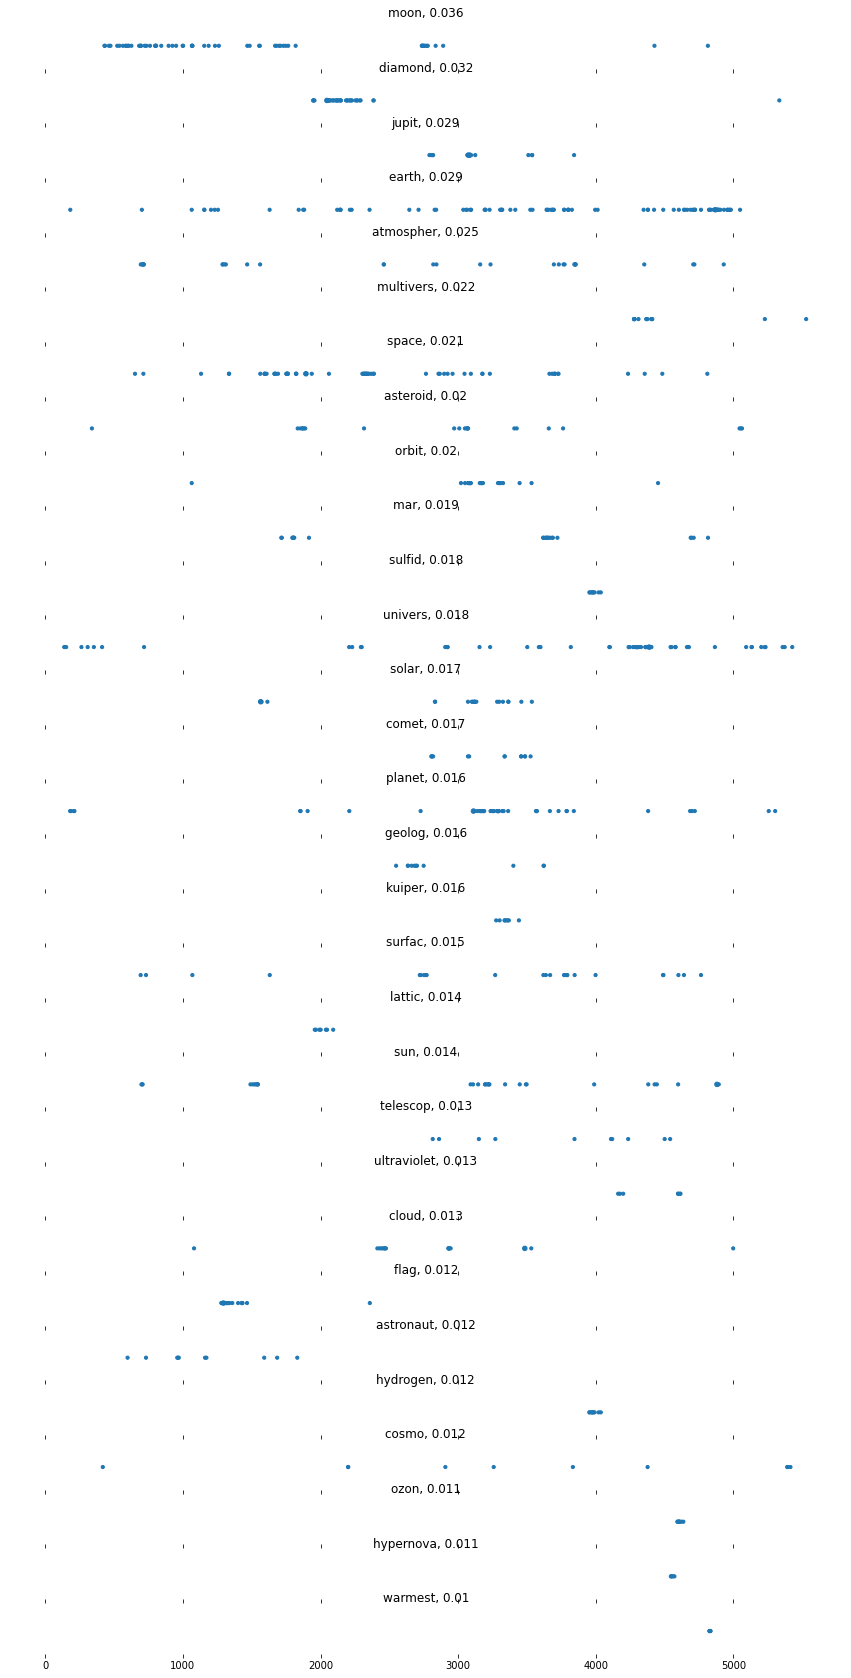

In [13]:
n_rows=30
fig, axs = plt.subplots(nrows=n_rows, sharex=True, figsize=(15, n_rows))

def setup_ax(ax):
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_yaxis().set_visible(False)

for i, ax in enumerate(axs):
    setup_ax(ax)

    word, score = top_tfidf_scores_for_ep[i]
    occurrences = ep_tfidf.sentence_occurrences(word)
    x = [idx for idx, _ in occurrences]
    y = [0] * len(x)
    s = [frequency * 10 for _, frequency in occurrences]
    ax.title.set_text(f"{word}, {round(score, 3)}")
    ax.scatter(x, y, s=s)

plt.show()

# So this looks promising. These occurences seem to create natural clusters.
# Using https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
# I can see that MeanShift or VBGMM may help with clustering

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


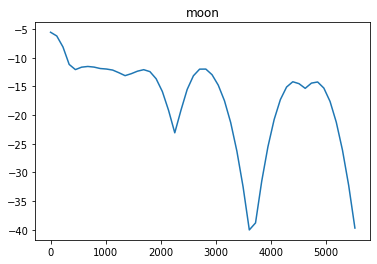

Number of clusters: 5
2 [430 434]
35 [ 462  474  523  539  564  584  588  602  605  626  682  692  693  696
  723  735  761  799  800  801  806  843  896  924  951  998 1002 1065
 1067 1068 1069 1155 1187 1233 1261]
12 [1468 1485 1554 1559 1670 1680 1699 1709 1730 1747 1765 1819]
11 [2736 2737 2740 2742 2749 2752 2761 2773 2779 2836 2891]
1 [4426]



In [14]:
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelextrema
from copy import deepcopy

def create_cluster(word, score, occurrences, plot=False):
    """
    At first I tried MeanShift but I couldn't get any good results,
    then I found this: https://stackoverflow.com/a/35151947/5770245
    """
    occurrences = ep_tfidf.sentence_occurrences(word)
    frequencies = deepcopy([f for _, f in occurrences])
    sizes = [frequency * 25 for frequency in frequencies]
    
    X = [frequency for _, frequency in occurrences]    
    X = [np.array([i]) if frequency > 0 else [-1] for i, frequency in enumerate(X)]    
    X = np.array(X).flatten()
    X = X.reshape(-1, 1)
    
    # TODO Use silverman's algorithm to guess bandwidth
    # For now, 100 seems to do a decent job
    # TODO Try triangle kernel
    # TODO There is probably bias at the boundaries, should mirror X
    kde = KernelDensity(kernel='gaussian', bandwidth=100).fit(X)
    s = np.linspace(0, len(occurrences))
    e = kde.score_samples(s.reshape(-1,1))
    # Reshape back to a 1 by N array
    X = X.reshape(1, -1) 

    minima = argrelextrema(e, np.less)[0]
    # Use the linspace to convert back into word indexes
    minima = [s[m] for m in minima]
    # (0, minima 1), (minima 1, minima 2), ... (minima n-1, minima n)
    minima_pairs = list(zip(np.insert(minima, 0, 0)[:-1], minima))

    clusters = [np.unique(X[np.logical_and(X >= m1, X < m2)]) for m1, m2 in minima_pairs]
    # Filter arrays with no values
    clusters = [c for c in clusters if len(c) > 0]
    
    def in_cluster_index(idx):
        # Returns the index of the cluster that a given index is in
        # TODO must be a better way to do this
        for i, c in enumerate(clusters):
            if idx in c:
                return i

        return -1

    labels = [in_cluster_index(i) for i in range(len(occurrences))]

    if plot:
        plt.plot(s, e)
        plt.title(word)
        plt.show()
        print(f"Number of clusters: {len(clusters)}")
        for c in clusters:
            print(len(c), c)

    return sizes, clusters, labels

word, score = top_tfidf_scores_for_ep[0]
occurrences = ep_tfidf.sentence_occurrences(word)
create_cluster(word, score, occurrences, plot=True)
print()

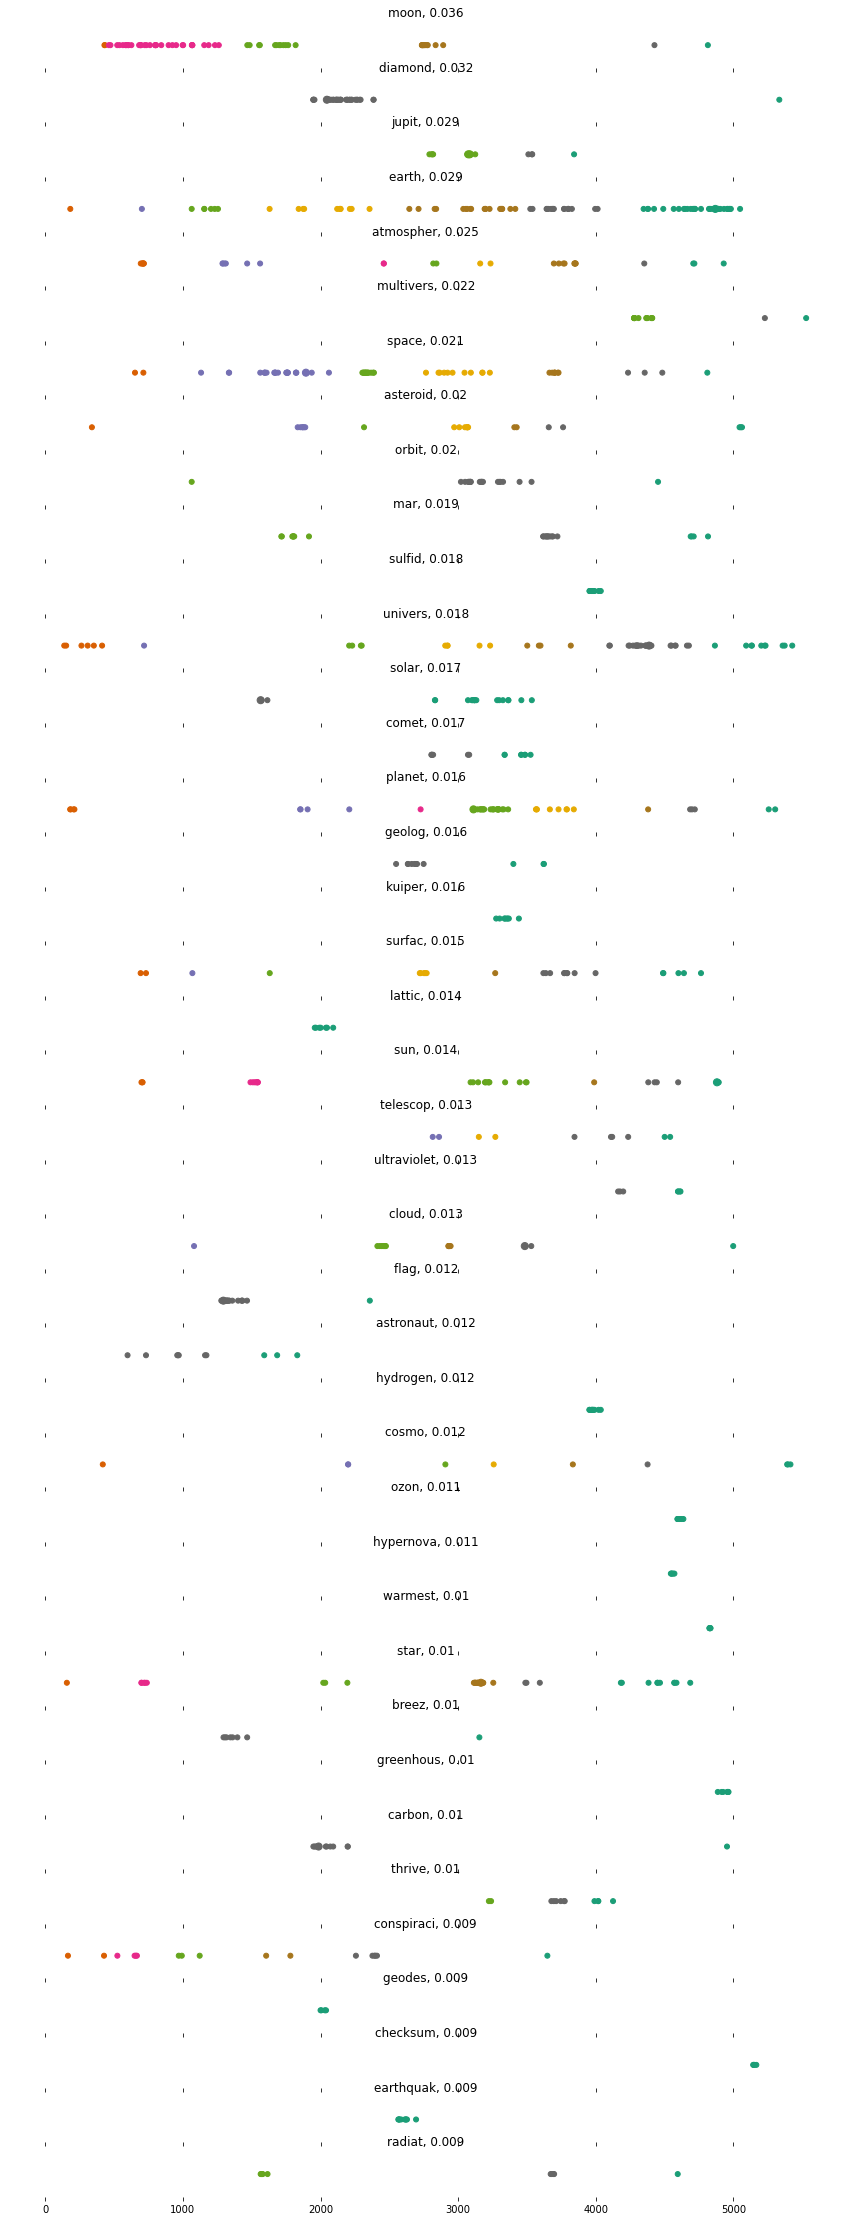

In [15]:
n_rows = 40
fig, axs = plt.subplots(nrows=n_rows, sharex=True, figsize=(15, n_rows))

x = [idx for idx, _ in occurrences]
y = [0] * len(x)
for i, ax in enumerate(axs):
    setup_ax(ax)

    word, score = top_tfidf_scores_for_ep[i]
    occurrences = ep_tfidf.sentence_occurrences(word)
    sizes, clusters, colors = create_cluster(word, score, occurrences)
    
    ax.title.set_text(f"{word}, {round(score, 3)}")
    ax.scatter(x, y, s=sizes, c=colors, cmap='Dark2')

plt.show()


In [16]:
# Calculate the first 50 word clusters
# word cluster = ([list of words], [ocurrences])
word_clusters = []
for i in tqdm(range(50)):
    word, score = top_tfidf_scores_for_ep[i]
    occurrences = ep_tfidf.sentence_occurrences(word)
    _, clusters, _ = create_cluster(word, score, occurrences)
    word_clusters.extend([([word], cluster) for cluster in clusters])

100%|██████████| 50/50 [00:03<00:00, 12.88it/s]


In [17]:
for w, c in word_clusters[:20]:
    print(w, c)

['moon'] [430 434]
['moon'] [ 462  474  523  539  564  584  588  602  605  626  682  692  693  696
  723  735  761  799  800  801  806  843  896  924  951  998 1002 1065
 1067 1068 1069 1155 1187 1233 1261]
['moon'] [1468 1485 1554 1559 1670 1680 1699 1709 1730 1747 1765 1819]
['moon'] [2736 2737 2740 2742 2749 2752 2761 2773 2779 2836 2891]
['moon'] [4426]
['diamond'] [1947 1948 1950 1956 2046 2049 2051 2053 2054 2055 2058 2060 2064 2069
 2081 2093 2095 2112 2115 2119 2125 2132 2143 2146 2148 2185 2193 2195
 2211 2213 2225 2227 2253 2263 2268 2285 2291 2384 2386]
['jupit'] [2791 2806 2813 2818 3067 3073 3078 3079 3082 3083 3084 3085 3094 3124]
['jupit'] [3510 3536 3538]
['earth'] [182]
['earth'] [702]
['earth'] [1064 1155 1156 1204 1231 1255]
['earth'] [1630 1841 1874 1881 2121 2139 2144 2146 2213 2226 2356]
['earth'] [2645 2712 2829 2840 3037 3056 3066 3089 3094 3192 3197 3199 3228 3305
 3311 3318 3320 3379 3415]
['earth'] [3524 3540 3642 3646 3656 3675 3686 3689 3695 3769 3770 3798 

In [18]:
def is_partially_contained(line_a, line_b, amount):
    """
    line_x: tuple where 0th element is start, 1th element is end
    amount: amount line b should overlap with line a (ratio between 0 and 1)
    """
    a_length, b_length = line_a[1] - line_a[0], line_b[1] - line_b[0]
    dist_start = np.absolute(line_a[0] - line_b[0])
    dist_end = np.absolute(line_a[1] - line_b[1])
#     print(dist_start, dist_end)
#     print(ratio * b_length)
#     print("b_length - dist_end", b_length - dist_end)
#     print("b_length - dist_start", b_length - dist_start)
#     print("dist_start + dist_end < ratio * a_length", dist_start + dist_end < ratio * a_length)
#     print("b_length - dist_end > ratio * b_length", b_length - dist_end > ratio * b_length)
#     print("b_length - dist_start > ratio * b_length", b_length - dist_start > ratio * b_length)
    return dist_start + dist_end < amount * a_length #\
#         or b_length - dist_end > ratio * b_length \
#         or b_length - dist_start > ratio * b_length \

def is_fully_contained(line_a, line_b):
    return line_b[0] >= line_a[0] and line_b[1] <= line_a[1]

### Examples
#    0   --------
#    0 --------
assert True == is_partially_contained((2, 10), (0, 8), .75)
#    0 ----------
#    0    --------
assert True == is_partially_contained((0, 10), (3, 11), .75)
#    0 ----------
#    0      -------
assert True == is_partially_contained((0, 10), (5, 12), .75)
#    0 ------------
#    0    -------------
assert True == is_partially_contained((0, 12), (3, 16), .75)
#    0  ----------
#    0 --------------
assert True == is_partially_contained((1, 10), (0, 14), .75) 
#    0 --------
#    0 --------------
assert False == is_partially_contained((0, 8), (0, 14), .75)
assert True == is_partially_contained((138, 413), (298, 452), .75)

In [19]:
# Naive cluster combining algorithm:
# Take first word_cluster and see if an item from another cluster falls into it
# An item "falls" into a cluster if there is a > 75% overlap and the child cluster is smaller
# than the one we are comparing

def combine_word_clusters(word_clusters, log=False):
    combined = []
    # Keep track of what clusters we have already combined into a different cluster
    closed_list = []
    metrics_added = []

    params = {
        'overlap': 0.75
    }
    
    def LOGGER(*args):
        if not log: return
        if type(args) is str or type(args) is int: print(args)
        else:
            print(" ".join([str(x) for x in args]))

    def get_length_count(cluster):
        length = np.max(cluster) - np.min(cluster)
        count = len(cluster)
        return length, count

    for i, wc in enumerate(word_clusters):
        combined.append([])
        if i in closed_list: continue
            
        # Copy values into new arrays
        words = [w for w in wc[0]]
        cluster = np.array([c for c in wc[1]])        
        
        length, count = get_length_count(cluster)
        cluster_extent = (np.min(cluster), np.max(cluster))
        combined[i] = (deepcopy(words), deepcopy(cluster))
        closed_list.append(i)

        LOGGER("===========")
        LOGGER(words[0], i)
        LOGGER(np.min(cluster), np.max(cluster))
        LOGGER(length)
        LOGGER("===========")

        for ii, swc in enumerate(word_clusters):
            if ii <= i or ii in closed_list: continue
            
            # Copy values into new arrays
            sub_cluster_words = [w for w in swc[0]]
            sub_cluster = np.array([c for c in swc[1]])   
            
            sub_cluster_length, sub_cluster_count = get_length_count(sub_cluster)
            sub_cluster_extent = (np.min(sub_cluster), np.max(sub_cluster))
            partially_contained = is_partially_contained(cluster_extent, sub_cluster_extent, params['overlap'])
            # Sub cluster falls completely inside cluster
#             fully_contained = np.min(sub_cluster) >= np.min(cluster) and np.max(sub_cluster) <= np.max(cluster)
            fully_contained = is_fully_contained(cluster_extent, sub_cluster_extent)
            
            # If both of the lengths are 0 (single dot) then (overlap >=...) if statement evaluates
            # as True. That is only okay if both clusters contain the same one sentence
            if length == 0 and sub_cluster_length == 0 and cluster[0] != sub_cluster[0]: 
                continue

            # TODO Do I need the `and sub_cluster_length <= length`?
            if fully_contained or partially_contained:# (partially_contained and sub_cluster_length <= length):
                LOGGER(sub_cluster_words[0], ii)
                LOGGER("\t", np.min(sub_cluster), np.max(sub_cluster))
                LOGGER("\tLength", sub_cluster_length)
                LOGGER("******")
                LOGGER("adding", sub_cluster_words, ii)
                LOGGER("to", words, i)
                LOGGER("before sub", np.unique(sub_cluster))

                closed_list.append(ii)
                
                words__, cluster__ = combined[i]
                LOGGER("before cluster", np.unique(cluster__))                
                cluster = np.hstack((cluster__, sub_cluster))
                LOGGER("after cluster", np.unique(cluster__))    
                
                metrics_added.append((f"{sub_cluster_words}\t\t @ {np.min(sub_cluster)}-{np.max(sub_cluster)} "
                                      + f"\t\t--> {words__} [{np.min(cluster__)}-{np.max(cluster__)}]", np.unique(cluster__)))
                
                words__.extend(sub_cluster_words)
                words__ = list(set(words__))
                                
                combined[i] = words__, cluster__
                print(i, combined[i])


    print("======")
    print("added",len(metrics_added))
    for c,m in metrics_added:
        print(c)
        
        
    combined = [wc for wc in combined if wc is not None and len(wc) == 2]
    combined = [(w, np.unique(c)) for w, c in combined]
    
    
    # Sort by number of words in a cluster
#     combined = sorted(combined, key=lambda x: len(x[1]), reverse=True)
    # TODO REMOVE?
    
    
    # Sort by time 
    combined = sorted(combined, key=lambda x: np.min(x[1]))
    
    
    return combined
    
# word_clusters_combined = sorted(word_clusters, key=lambda x: np.min(x[1]))
word_clusters_combined = combine_word_clusters(word_clusters)
# Collapse again
for i in range(20):
    word_clusters_combined = combine_word_clusters(word_clusters_combined, log=False)
    

1 (['moon', 'earth'], array([ 462,  474,  523,  539,  564,  584,  588,  602,  605,  626,  682,
        692,  693,  696,  723,  735,  761,  799,  800,  801,  806,  843,
        896,  924,  951,  998, 1002, 1065, 1067, 1068, 1069, 1155, 1187,
       1233, 1261]))
1 (['moon', 'earth'], array([ 462,  474,  523,  539,  564,  584,  588,  602,  605,  626,  682,
        692,  693,  696,  723,  735,  761,  799,  800,  801,  806,  843,
        896,  924,  951,  998, 1002, 1065, 1067, 1068, 1069, 1155, 1187,
       1233, 1261]))
1 (['moon', 'earth', 'atmospher'], array([ 462,  474,  523,  539,  564,  584,  588,  602,  605,  626,  682,
        692,  693,  696,  723,  735,  761,  799,  800,  801,  806,  843,
        896,  924,  951,  998, 1002, 1065, 1067, 1068, 1069, 1155, 1187,
       1233, 1261]))
1 (['moon', 'earth', 'space', 'atmospher'], array([ 462,  474,  523,  539,  564,  584,  588,  602,  605,  626,  682,
        692,  693,  696,  723,  735,  761,  799,  800,  801,  806,  843,
        896

added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0
added 0


In [20]:
for words, clusters in word_clusters_combined:
    print("words:", len(words), words[:3], "n in cluster:", len(clusters))

words: 8 ['conspiraci', 'planet', 'asteroid'] n in cluster: 6
words: 1 ['cosmo'] n in cluster: 1
words: 1 ['moon'] n in cluster: 2
words: 14 ['orbit', 'conspiraci', 'earth'] n in cluster: 35
words: 11 ['conspiraci', 'radiat', 'space'] n in cluster: 27
words: 11 ['planet', 'asteroid', 'earth'] n in cluster: 11
words: 2 ['conspiraci', 'space'] n in cluster: 5
words: 1 ['chemtrail'] n in cluster: 5
words: 2 ['cloud', 'atmospher'] n in cluster: 7
words: 1 ['geolog'] n in cluster: 8
words: 23 ['jupit', 'thrive', 'atmospher'] n in cluster: 19
words: 2 ['extinct', 'asteroid'] n in cluster: 6
words: 2 ['jupit', 'cloud'] n in cluster: 2
words: 1 ['star'] n in cluster: 3
words: 15 ['planet', 'asteroid', 'earth'] n in cluster: 17
words: 2 ['gase', 'telescop'] n in cluster: 4
words: 11 ['multivers', 'planet', 'ultraviolet'] n in cluster: 29
words: 1 ['planet'] n in cluster: 3
words: 1 ['multivers'] n in cluster: 1


In [21]:
word_clusters_sorted_by_time = sorted(word_clusters_combined, key=lambda x: np.min(x[1]))
for words, cluster in word_clusters_sorted_by_time:
    print("words:", len(words), words[:3], "n in cluster:", len(cluster), 
          f"{np.min(cluster)}-{np.max(cluster)}")

words: 8 ['conspiraci', 'planet', 'asteroid'] n in cluster: 6 138-413
words: 1 ['cosmo'] n in cluster: 1 418-418
words: 1 ['moon'] n in cluster: 2 430-434
words: 14 ['orbit', 'conspiraci', 'earth'] n in cluster: 35 462-1261
words: 11 ['conspiraci', 'radiat', 'space'] n in cluster: 27 1132-2061
words: 11 ['planet', 'asteroid', 'earth'] n in cluster: 11 1630-2356
words: 2 ['conspiraci', 'space'] n in cluster: 5 2257-2410
words: 1 ['chemtrail'] n in cluster: 5 2399-2429
words: 2 ['cloud', 'atmospher'] n in cluster: 7 2413-2475
words: 1 ['geolog'] n in cluster: 8 2549-2749
words: 23 ['jupit', 'thrive', 'atmospher'] n in cluster: 19 2645-3415
words: 2 ['extinct', 'asteroid'] n in cluster: 6 3377-3525
words: 2 ['jupit', 'cloud'] n in cluster: 2 3484-3531
words: 1 ['star'] n in cluster: 3 3488-3593
words: 15 ['planet', 'asteroid', 'earth'] n in cluster: 17 3524-4013
words: 2 ['gase', 'telescop'] n in cluster: 4 3845-4235
words: 11 ['multivers', 'planet', 'ultraviolet'] n in cluster: 29 4098-4

In [22]:
def plot_word_clusters_combined(word_clusters_combined):
    n_rows = len(word_clusters_combined)
    fig, axs = plt.subplots(nrows=n_rows, sharex=True, figsize=(15, n_rows))

    x = [idx for idx, _ in occurrences]
    y = [0] * len(x)
    bubble_size = 25
    for i, ax in tqdm(enumerate(axs)):
        setup_ax(ax)

        words, cluster = word_clusters_combined[i]
        s = [bubble_size if idx in cluster else 0 for idx, _ in occurrences]

        ax.title.set_text(f"{', '.join(words[:10])}, ({len(words)})")
        ax.scatter(x, y, s=s, cmap='Dark2')

    plt.show()

19it [00:01, 12.95it/s]


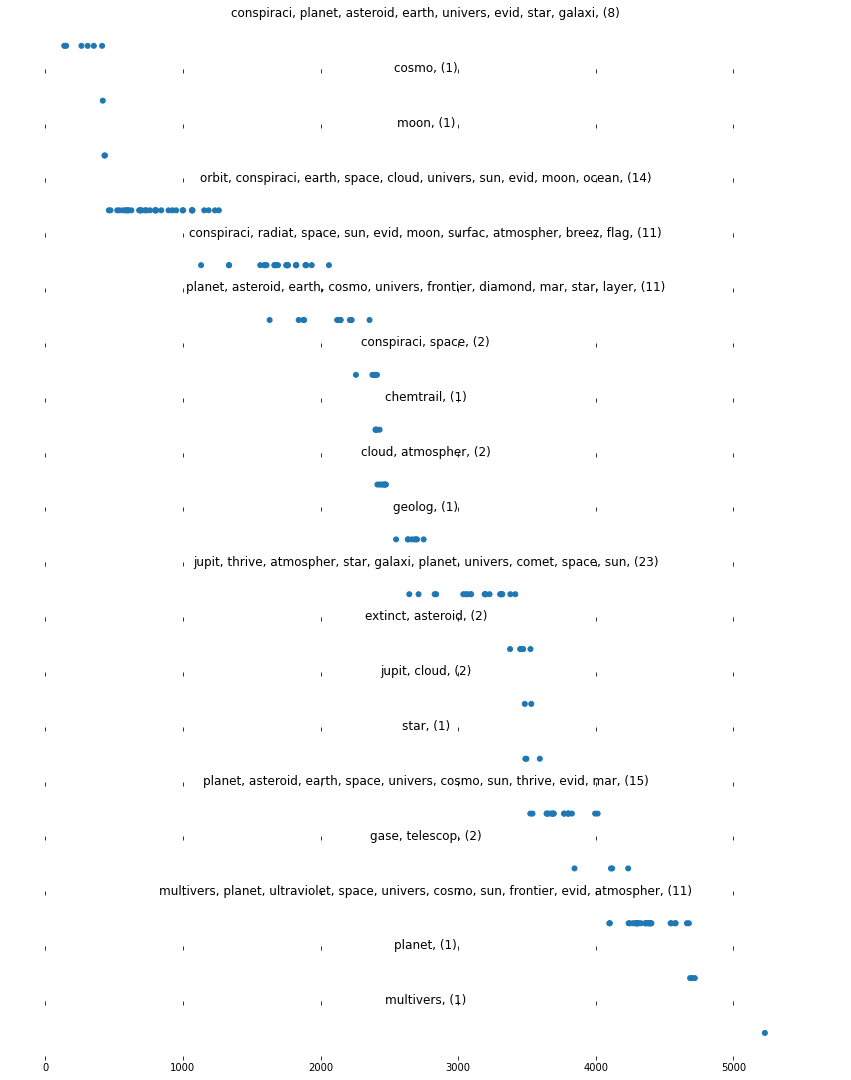

In [23]:
plot_word_clusters_combined(word_clusters_combined)

13it [00:00, 13.24it/s]


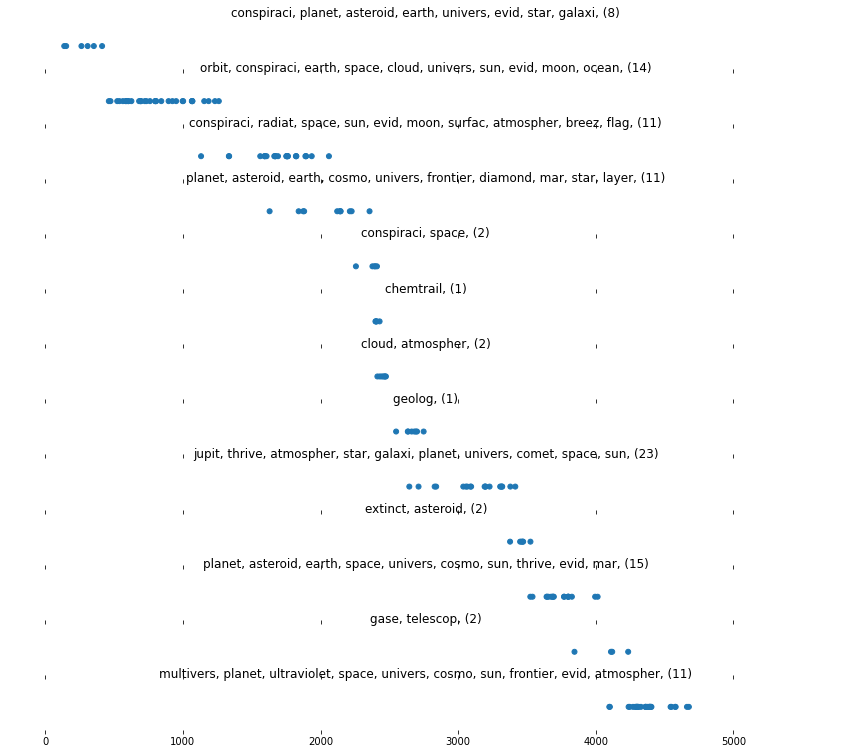

In [31]:
# TODO This 3 is an arbitrary number
word_clusters_filtered = [wc for wc in word_clusters_combined if len(wc[1]) > 3]
plot_word_clusters_combined(word_clusters_filtered)
# word_clusters_filtered[1]

In [25]:
for i, (words, cluster) in enumerate(word_clusters_combined):
    start, end = np.min(cluster), np.max(cluster)
    print(i, f"{start}-{end}", " ".join(words[:10]))
    print(" =========== ")
    print(" ".join(sentences[start:end]), end="\n\n")

0 138-413 conspiraci planet asteroid earth univers evid star galaxi
universe is gonna explode you are sure the most requested podcast guests ever in the history of this podcast so Brian and I have been doing this for three years and we have come full cycle with your appearance here today I have I felt the magnetic force of your fan base pulling me in you sure that wasn't what the Mayans were talking about I'm sure that wasn't the universe aligning I was so happy when I saw you do this I forget what the interview was but someone was talking about the alignment of the stars and the galaxies the first time in your like know it happens all the time yeah it happens every year yeah I told my friend Eddie Bravo who's a beautiful human being but he loves himself a conspiracy theory he loves that when I told him I go dude Neil Tyson says it's [ __ ] he goes like this oh okay well yeah probably [ __ ] that I don't want the authority of my academic pedigree to be what makes it [ __ ] right i mean

In [26]:
i = 0
chunk_size = 5
caption_chunks = []

# first element of each chunk corresponds to the sentence number
for caption in ep.captions:
    caption_chunks.append((i // chunk_size, caption))
    i = i + len(caption.text.split())

In [37]:
# Make clusters into topics (documents with respect to the episode as the corpus)
# Kinda a crude way of doing this, ignores the real topic start
start = 0
last = start
topics = []
topics_captions = []

for _, cluster in word_clusters_filtered:
    start = np.min(cluster)
    end = np.max(cluster)
    topics.append(" ".join(sentences[start:end]))
    captions = [caption for idx, caption in caption_chunks if idx >= start and idx <= end]
    topics_captions.append((captions[0], captions[-1]))
#     last = start
#     start = end    
    
tfidf_topics = TFIDF()
tfidf_topics.generate(topics)

def to_timestamp(caption, end=False): 
    seconds = caption.start + caption.duration if end else caption.start
    minutes = f"{round(seconds / 60 % 60)}"
    minutes = minutes.zfill(2)
    return f"{round(seconds / 60 // 60)}:{minutes}"
topics_timestamps = [f"{to_timestamp(c_start)}-{to_timestamp(c_end, True)}" for c_start, c_end in topics_captions]

topics_timestamps

100%|██████████| 13/13 [00:00<00:00, 308.68it/s]


['0:03-0:10',
 '0:12-0:33',
 '0:29-0:54',
 '0:42-1:02',
 '0:59-1:04',
 '1:03-1:04',
 '1:04-1:05',
 '1:07-1:13',
 '1:09-1:32',
 '1:31-1:35',
 '1:35-1:50',
 '1:45-1:57',
 '1:53-2:10']

In [38]:
for i,_ in enumerate(topics):
    print(topics_timestamps[i])
    print("-----")
    for w, s in tfidf_topics.get_scores(i)[:15]:
        print(w, f"{round(s * 100, 2)}%")
    print()

0:03-0:10
-----
duran 3.62%
align 3.02%
associ 2.42%
import 2.16%
happi 1.81%
mayan 1.81%
forget 1.81%
love 1.52%
enjoy 1.42%
gon 1.27%
na 1.27%
nutti 1.21%
relationship 1.21%
encourag 1.21%
bullshit 1.21%

0:12-0:33
-----
secret 3.88%
moon 3.09%
clinton 1.92%
pound 1.72%
hoax 1.65%
photo 1.51%
documentari 1.51%
trampolin 1.37%
lie 1.37%
dust 1.29%
astronaut 1.21%
footag 1.08%
sky 1.04%
quot 1.04%
govern 1.04%

0:29-0:54
-----
flag 3.79%
diamond 1.89%
pound 1.81%
hop 1.61%
fake 1.53%
russia 1.45%
carbon 1.44%
heavi 1.44%
breez 1.26%
footag 1.26%
dust 1.26%
space 1.22%
moon 1.22%
mar 1.16%
lattic 1.08%

0:42-1:02
-----
diamond 6.14%
carbon 2.41%
russia 1.62%
technolog 1.62%
heavi 1.61%
space 1.56%
lattic 1.41%
mar 1.29%
pencil 1.21%
unless 1.13%
market 1.13%
dome 1.01%
comput 1.01%
robot 1.01%
price 1.01%

0:59-1:04
-----
price 3.26%
diamond 3.14%
resourc 2.62%
space 2.29%
chemtrail 2.1%
market 2.1%
crop 1.96%
marketplac 1.96%
privat 1.66%
obama 1.66%
plot 1.3%
naiv 1.3%
unrealist 1.3%


In [29]:
topics[1]

"the universe when in fact they did not well they understood the little bit of it but to say that they knew more about the fate of the cosmos than modern day astrophysics you must have wanted your path classy of physics classes or something to think that way I don't understand what's going on in those mind it's the same sort of thinking that the same thinking that wants to uncover mysteries and conspiracies there's a there's it's a weird excitement to like hidden things now you're a moon guy for a while right yeah well I listen my issues with not believing that people went on the moon a lot of it had to do with a friend who had an aunt who worked at Rocketdyne and this guy was convinced that there was no way to do it he was an engineer and he said they were so far away from doing it that the fact that they did it and they did it seven times but I since looking at it the weight of all the evidence the road I reserved the possibility that some things were horseshit based on a lot of phot

In [30]:
"""
NaiveTopicSegmenter
    __init__
        most important words : list[str]
        corpus : list[str]


def word_index_to_caption(episode, word_index):
    return

episode = episodes[0]
most_common_words = tfidf[episode.title]
most_common_words_sparse = (episode, most_common_words) -> [(word, [indices])]
clusters = [  ([word_s], [cluster]) , ...  ]
clusters = [  ([words], [cluster]) , ...  ]

"""

"""
@dataclass
class WordCluster:
    words: List[str]
    indices: List[int]

class WordClusters:
    # List of all words in corpus
    corpus: List[str]
    clusters: List[WordCluster]
    
    def plot():
        # Group clusters by word
        pass
    
    def condense():
        pass
        
    def condenser():
        pass
"""

'Joe Rogan Experience #310 - Neil Degrasse Tyson'